## Who is the most consistent player in the NBA?
In this post I will try to figure out who is the most consistent player during the 2016-17 season using python and the NBA api. My goal is to find how consistent a player is from one game to another and therefore I need to be able to measure the performnce on a game by game basis. In order to do that I'm using a player's [gamescore](http://www.basketball-reference.com/about/glossary.html - GmSc) since it allows to calculate productivity per game from the boxscore. 

In [1]:
%matplotlib inline
import NBAapi as nba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import progressbar
from bokeh.plotting import figure, show
from bokeh.charts import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool
import time

output_notebook()

Loading BokehJS ...

Let's write a function that calculates the gamescore: 

In [2]:
def gamescore(df):
    '''
    gamescore accepts a DataFrame with boxscore infromation and computes the gamescore for each game
    '''
    Points = df['PTS'].values
    FGM = df['FGM'].values
    FGA = df['FGA'].values
    FTM = df['FTM'].values
    FTA = df['FTA'].values
    OREB = df['OREB'].values
    DREB = df['DREB'].values
    STL = df['STL'].values
    AST = df['AST'].values
    BLK = df['BLK'].values
    TO = df['TOV'].values
    PF = df['PF'].values
    return 1.0*Points + 0.4*FGM - 0.7*FGA - 0.4*(FTA-FTM) + 0.7*OREB + 0.3*DREB + STL + 0.7*AST + 0.7*BLK -0.4*PF - TO

First, we need to load the boxscore information for each player and then calculate the gamescore for each of those games. For example I can load the game log data for LeBron James and Anthony Davis from the NBA api and compare the distribution of gamescores for each player using a histogram:

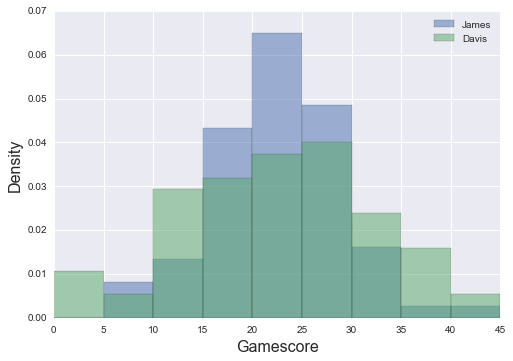

In [3]:
player_list = nba.player.commonallplayers(currentseason=1,season='2016-17') # load a current list of NBA players 
james_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']=='James, LeBron'].PERSON_ID # get players id
james_gamelog = nba.player.gamelog(james_id,Season='2016-17') # load all game logs
james_GS = gamescore(james_gamelog) # calculate game score for each game

# do the same for Anthony Davis
davis_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']=='Davis, Anthony'].PERSON_ID
davis_gamelog = nba.player.gamelog(davis_id,Season='2016-17')
davis_GS = gamescore(davis_gamelog)

# now we are ready to plot
plt.hist(james_GS,bins=np.arange(0,50,5),alpha=0.5,normed=True); # plot the distribution using a histogram
plt.hist(davis_GS,bins=np.arange(0,50,5),alpha=0.5,normed=True);
plt.legend(['James','Davis'])
plt.ylabel('Density',fontsize=16)
plt.xlabel('Gamescore',fontsize=16)

We can see that the average gamescore is about the same for both players but that James has a narrower distribution meaning that he is more consistent.

Now let's load the game logs for the 2016-17 season for each player and calculate the mean gamescore and the standard deviation:

In [4]:
player_gs = []
bar = progressbar.ProgressBar(max_value=len(player_list)) # create status bar for download
for i,player_id in enumerate(player_list.PERSON_ID):
    player_gamelog = nba.player.gamelog(player_id,Season='2016-17')
    GS = gamescore(player_gamelog)
    if len(player_gamelog)!=0:
        player_gs.append([np.mean(GS),np.std(GS),len(player_gamelog)])  # create list with mean,std and game played
    else:
        player_gs.append([0,0,0]) # if player did not play insert 0s
    bar.update(i)
    time.sleep(0.5) # sometimes NBA api seems to get stuck with freequent calls
df = pd.DataFrame(player_gs,index=player_list.DISPLAY_LAST_COMMA_FIRST,columns=['GAMESCORE_MEAN','GAMESCORE_STD','GP'])
np.round(df.head(),2)

 99% (490 of 491) |############################################################################ | Elapsed Time: 0:07:34 ETA: 0:00:00

,GAMESCORE_MEAN,GAMESCORE_STD,GP
DISPLAY_LAST_COMMA_FIRST,,,
"Abrines, Alex",3.59,3.93,68
"Acy, Quincy",4.13,4.49,38
"Adams, Steven",10.40,5.48,80
"Afflalo, Arron",5.38,4.67,61
"Ajinca, Alexis",4.28,4.44,39


We can now plot the standard deviation (std) and mean gamescore for each player in the league:

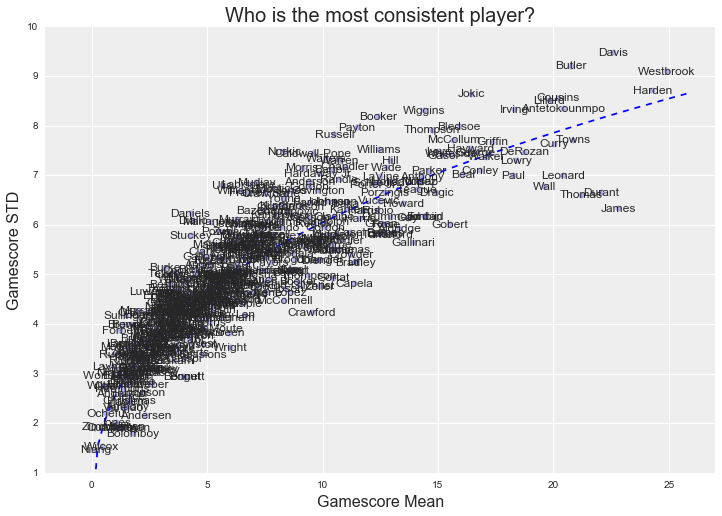

In [5]:
mask = df.GP>=10 # Only include players that played over 10 games
p = np.polyfit(np.log10(df.GAMESCORE_MEAN[mask]),np.log10(df.GAMESCORE_STD[mask]),1) # powerlaw fit y=ax^b
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,8))
ax.grid(color='white', linestyle='solid')
scatter = ax.scatter(df.GAMESCORE_MEAN[mask],df.GAMESCORE_STD[mask],s = 30,alpha=0.25) # scatter plot
# write players name on top of scatter plot
for x,y,name in zip(df.GAMESCORE_MEAN[mask],df.GAMESCORE_STD[mask],df.index[mask]):
    ax.text(x,y,name.split(',')[0],horizontalalignment='center',verticalalignment='center')
plt.title('Who is the most consistent player?',fontsize=20)   
plt.xlabel('Gamescore Mean',fontsize=16)
plt.ylabel('Gamescore STD',fontsize=16)
plt.xlim([-2,27])
plt.ylim([1,10])

# plot powerlaw fit on top of data
x= np.linspace(0,26,100)
a = 10**p[1]
b = p[0]
plt.plot(x,a*x**b,'--b')

We can use the Bokeh to get an interactive plot. If you hover over the data point with the mouse the name of the player and the gamescore mean and std appears on the figure: 

In [6]:
source = ColumnDataSource(df.loc[mask,:].reset_index())

# create hover tool
hover = HoverTool(
        tooltips=[
            ("Player", "@DISPLAY_LAST_COMMA_FIRST"),
            ("mean", "@GAMESCORE_MEAN"),
            ("std", "@GAMESCORE_STD"),
        ]
    )

p = figure(plot_width=800, plot_height=500, tools=[hover],title='Who is the most consistent player?')

p.circle('GAMESCORE_MEAN', 'GAMESCORE_STD', size=7, fill_alpha=0.5,source=source) # scatter plot
p.line(x=x, y=a*x**b,color='black') # powerlaw fit
p.xaxis.axis_label = "Gamescore Mean"
p.yaxis.axis_label = "Gamescore STD"

show(p)

We see a strong correlations between the mean gamescore and the std. This means that a player that contributes more tends to have larger swings around the average. This makes sense! When you don't produce much the fluctuations are smaller. But it also means that it is harder to compare the consistency of players with different productivity.

We can try to compare players with similar gamescores to see who is more consistent. 
If we look at the players with gamescore above 20, **James** is the most consistent.
For players with a gamescore above 10, **Gobert** is the most consistent.

We can try and measure how volatile a player is. We can use the [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) for that which measures the disparity relative to the output (i.e. std/mean). This shows how much a players gamescore fluctuates relative to his mean output:

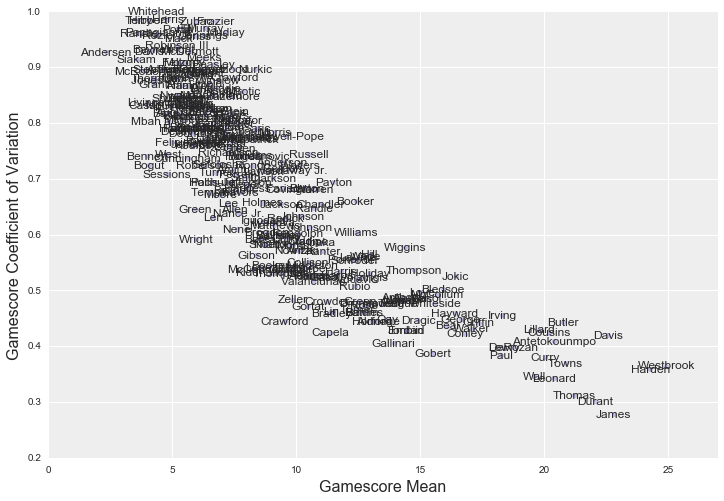

In [7]:
df['GAMESCORE_CV'] = df.GAMESCORE_STD/np.abs(df.GAMESCORE_MEAN) # create new column with coefficient of variation

mask = (df.GP>=10) & (df.GAMESCORE_CV<1) # create mask

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,8))
ax.grid(color='white', linestyle='solid')
plt.scatter(df.GAMESCORE_MEAN[mask],df.GAMESCORE_CV[mask],alpha=0.2)
# write player names of figure
for x,y,name in zip(df.GAMESCORE_MEAN[mask],df.GAMESCORE_CV[mask],df.index[mask]):
    plt.text(x,y,name.split(',')[0],horizontalalignment='center',verticalalignment='center')
plt.ylim([0.2,1])
plt.xlim([0,27])
plt.xlabel('Gamescore Mean',fontsize=16)
plt.ylabel('Gamescore Coefficient of Variation',fontsize=16)

We can use an interactive plot again:

In [8]:
source = ColumnDataSource(df.loc[mask,:].reset_index())
hover = HoverTool(
        tooltips=[
            ("Player", "@DISPLAY_LAST_COMMA_FIRST"),
            ("mean", "@GAMESCORE_MEAN"),
            ("CV", "@GAMESCORE_CV"),
        ]
    )
p = figure(plot_width=800, plot_height=500, tools=[hover],title='Who is the most consistent?')

p.circle('GAMESCORE_MEAN', 'GAMESCORE_CV', size=7, fill_alpha=0.5,source=source)
p.xaxis.axis_label = "Gamescore Mean"
p.yaxis.axis_label = "Gamescore CV"

show(p)

In this case it is clear the LeBron and the most consistent player with Durant and Thomas close beind.

We can also see it in a table format:

In [9]:
np.round(df.loc[mask,:].sort_values(by='GAMESCORE_CV').reset_index().head(15),2)

,DISPLAY_LAST_COMMA_FIRST,GAMESCORE_MEAN,GAMESCORE_STD,GP,GAMESCORE_CV
0,"James, LeBron",22.80,6.33,74,0.28
1,"Durant, Kevin",22.06,6.67,62,0.30
2,"Thomas, Isaiah",21.20,6.61,76,0.31
3,"Leonard, Kawhi",20.41,7.00,74,0.34
4,"Wall, John",19.61,6.78,78,0.35
5,"Harden, James",24.28,8.72,81,0.36
6,"Westbrook, Russell",24.92,9.11,81,0.37
7,"Towns, Karl-Anthony",20.87,7.72,82,0.37
8,"Curry, Stephen",20.04,7.64,79,0.38
9,"Paul, Chris",18.25,7.01,61,0.38


We can also check a player's stability over time. Let's take LeBron James as an example:

In [10]:
years = np.arange(2003,2017)
seasons = []
james_gamelog = []
for year in years:
    string1 = str(year)
    string2 = str(year+1)
    season = '{}-{}'.format(string1,string2[-2:])
    temp = nba.player.gamelog(james_id,Season=season)
    temp['SEASON'] = season
    james_gamelog.append(temp)
    time.sleep(0.5)
df_james = pd.concat(james_gamelog,ignore_index=True)
df_james['GS'] = gamescore(df_james)
james_evolution = df_james.loc[:,['SEASON','GS']].groupby('SEASON').agg([np.size, np.mean, np.std])
james_evolution.columns = ['GP','GS_MEAN','GS_STD']
np.round(james_evolution,2)

,GP,GS_MEAN,GS_STD
SEASON,,,
2003-04,79.0,14.51,8.14
2004-05,80.0,22.10,7.64
2005-06,79.0,23.61,8.66
2006-07,78.0,20.34,6.68
2007-08,75.0,24.15,8.32
2008-09,81.0,24.27,7.67
2009-10,76.0,25.58,7.28
2010-11,79.0,21.74,7.30
2011-12,62.0,22.93,7.05


Let's plot it:

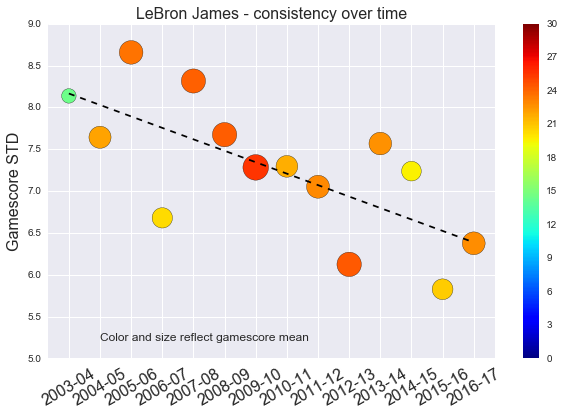

In [11]:
x = np.arange(len(james_evolution))
p = np.polyfit(x,james_evolution.GS_STD,1)
cm = matplotlib.cm.get_cmap('jet')
color = james_evolution.GS_MEAN
plt.figure(figsize=(10,6))
plt.scatter(x,james_evolution.GS_STD,s = james_evolution.GS_MEAN**2,c=color,vmin=0,vmax=30,cmap=cm);
plt.xticks(x, james_evolution.index, rotation=30,fontsize=16)
plt.colorbar()
plt.ylabel('Gamescore STD',fontsize=16)
plt.text(1.0,5.25,'Color and size reflect gamescore mean',verticalalignment='center',fontsize=12)
plt.title('LeBron James - consistency over time',fontsize=16)
plt.ylim([5.0,9.0])
plt.plot(x,p[0]*x+p[1],'k--')

Clearly LeBron is getting more consistent with time. This seems to agree with the intuition the experienced players tend to be more consistent but we only have an n of 1 so we are not going to jump to conclusions. We have seem that there is a correlation between a players gamescore mean and std but in LeBron's case his gamescore average is very consistent since his second year in the league.  

Let's try another player. This time I'm going to choose Tim Duncan:

In [12]:
player_list = nba.player.commonallplayers(currentseason=1,season='2015-16') # load a current list of NBA players 
duncan_id = player_list[player_list['DISPLAY_LAST_COMMA_FIRST']=='Duncan, Tim'].PERSON_ID # get players id
years = np.arange(1997,2016)
seasons = []
duncan_gamelog = []
for year in years:
    string1 = str(year)
    string2 = str(year+1)
    season = '{}-{}'.format(string1,string2[-2:])
    temp = nba.player.gamelog(duncan_id,Season=season)
    temp['SEASON'] = season
    duncan_gamelog.append(temp)
    time.sleep(0.5)
df_duncan = pd.concat(duncan_gamelog,ignore_index=True)
df_duncan['GS'] = gamescore(df_duncan)
duncan_evolution = df_duncan.loc[:,['SEASON','GS']].groupby('SEASON').agg([np.size, np.mean, np.std])
duncan_evolution.columns = ['GP','GS_MEAN','GS_STD']

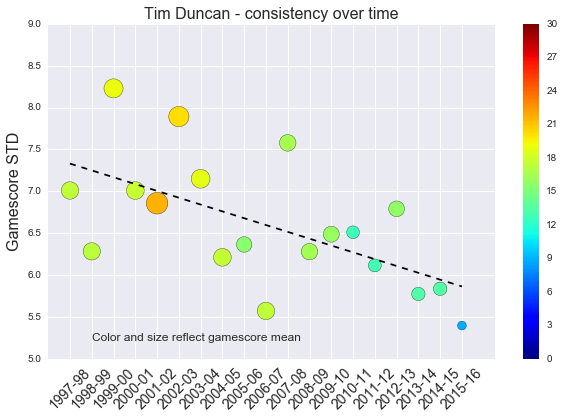

In [13]:
x = np.arange(len(duncan_evolution))
p = np.polyfit(x,duncan_evolution.GS_STD,1)
color = duncan_evolution.GS_MEAN
plt.figure(figsize=(10,6))
plt.scatter(x,duncan_evolution.GS_STD,s = duncan_evolution.GS_MEAN**2,c=color,vmin=0,vmax=30,cmap=cm);
plt.xticks(x, duncan_evolution.index, rotation=45,fontsize=14)
plt.colorbar()
plt.ylabel('Gamescore STD',fontsize=16)
plt.xlim([-1.0,len(duncan_evolution)+0.5])
plt.text(1.0,5.25,'Color and size reflect gamescore mean',verticalalignment='center',fontsize=12)
plt.title('Tim Duncan - consistency over time',fontsize=16)
plt.ylim([5.0,9.0])
plt.plot(x,p[0]*x+p[1],'k--')

We can also see a trend in Duncan's case but it also seems like his gamescore has been declining over the years which we know is correlated with lower std. Let's check the correlation between gamescore mean and std for Duncan's career. The color represents the number of years h has been in the league:

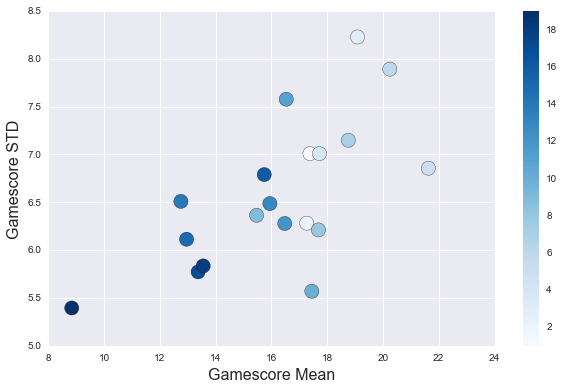

In [14]:
plt.figure(figsize=(10,6))
color = np.arange(1,len(duncan_evolution)+1)
plt.scatter(duncan_evolution.GS_MEAN,duncan_evolution.GS_STD,s=200,c=color,vmin=1,vmax=19,cmap=matplotlib.cm.get_cmap('Blues'))
plt.colorbar()
plt.xlabel('Gamescore Mean',fontsize=16)
plt.ylabel('Gamescore STD',fontsize=16)

And the same figure in Bokeh:

In [15]:
source = ColumnDataSource(duncan_evolution.reset_index())
hover = HoverTool(
        tooltips=[
            ("Season", "@SEASON"),
            ("mean", "@GS_MEAN"),
            ("std", "@GS_STD"),
        ]
    )

c = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*matplotlib.cm.Blues(matplotlib.colors.Normalize()(np.arange(len(duncan_evolution))))
]
p = figure(plot_width=600, plot_height=420, tools=[hover],title='Duncan')

p.circle('GS_MEAN', 'GS_STD', size=20, fill_color=c,source=source)
p.xaxis.axis_label = "Gamescore MEAN"
p.yaxis.axis_label = "Gamescore STD"
p.background_fill_color = "navy"
p.background_fill_alpha = 0.05

show(p)

This jupyter notebook can be downloaded [here](https://github.com/eyalshafran/Example-notebooks)

* I'm having some issues getting the Bokeh plots to show up with pelican. They work on the notebook.

## Let me know what you think.

References:
1. Gamescore formula - http://www.basketball-reference.com/about/glossary.html
2. Interactive plots - http://bokeh.pydata.org/en/latest/docs/user_guide/tools.html 